# Support & Resistance
S/R levels differ from one person to another. So we will try to draw a few examples. <br>
First let's import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Method 1:
Look for support by first, removing noise from signal with moving average. Offset by support value, then look for locations where offset value is at zero, which would be the locations touching the support line. <br>
<b>Downside:</b> Unfortunately using a moving average to filter and help to detect S/R levels isn't a good idea and results in very inaccurate lines!

support identified at days prior index 100 value: -8.01 touch inds: [44 51 59 98]
support identified at days prior index 130 value: -5.37 touch inds: [ 67  75  85 128]
support identified at days prior index 250 value: 8.55 touch inds: [211 215 219 248]
support identified at days prior index 260 value: 8.56 touch inds: [211 215 248 258]
support identified at days prior index 490 value: 20.66 touch inds: [392 395 397 480 488]


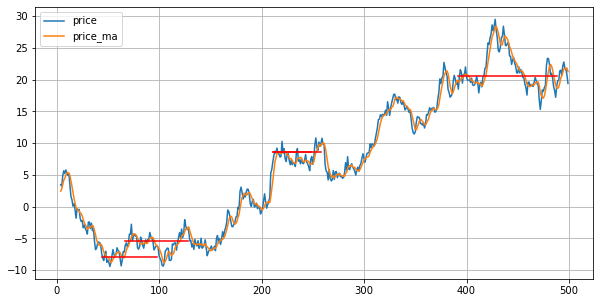

In [3]:
def get_support_line(df,days=100):
    df['price_ma']=df['price'].rolling(5).mean()
    df = df.dropna()
    supports={}

    for x in np.arange(0,len(df)-days,10):
        price_tmp = df.iloc[x:x+days]['price_ma'].values
        # offset signal by support value, loc crossing 0 will be support.
        support_val = price_tmp[-1]
        norm = price_tmp-support_val
        lim = 0.05 # hack to find intersect with support line with tolerance
        signal = np.logical_and(norm<lim,norm>-1*lim).astype(np.int32)
        inds = np.where(np.diff(signal)>0)[0]
        if np.sum(signal)>3:
            supports[x+days]={
                'x':inds+x,
                'y':support_val*np.ones(inds.shape)
            }
    return df, supports

# Simulate data
np.random.seed(42)
mu = 0.03
ret = mu+np.random.randn(500)
price = 1+np.cumsum(ret)

# Run the function
df = pd.DataFrame()
df['price']=price
df, supports = get_support_line(df)

# Plot
df.plot(figsize=(10,5))
for k,v in supports.items():
    print('support identified at days prior index',k,'value: {:1.2f}'.format(v['y'][0]),'touch inds:',v['x'])
    plt.plot([v['x'][0],v['x'][-1]],[v['y'][0],v['y'][-1]],color='red')
plt.grid(True)

### Method 2
<span>A very simple algorithm is to choose a timeframe, say 100 bars, then look for local turning points, or Maxima and Minima. Maxima and Minima can be computed from a smoothed closing price by using the 1st and second derivative (dy/dx and d^2y/dx). Where dy/dx = zero and d^y/dx is positive, you have a minima, when dy/dx = zero and d^2y/dx is negative, you have a maxima. (dy/dx: To differentiate a function you can compute [f(x+h) - f(x-h)] / 2h (where h=1 and f(x) is your input array). In practice this means if your array is length 10 (indices 0..9) then you compute diff[8] = (input[9] - input[7]) / 2. You can perform a more accurate differential using five points, by computing [f(x-2h) - 8f(x+h) + 8f(x-h) - f(x+2h)] / 12h. Again for our array of length 10 this means calculating diff[7] = (input[5] - 8* input[8] + 8* input[6] - input[9])/12. As you can see using more points to compute the derivative means you introduce more lag into the calculation.)</span><br>
In practical terms this could be computed by iterating over your smoothed closing price series and looking at three adjacent points. If the points are lower/higher/lower in relative terms then you have a maxima, else higher/lower/higher you have a minima. You may wish to fine-tune this detection method to look at more points (say 5, 7) and only trigger if the edge points are a certain % away from the centre point. this is similar to the algorithm that the ZigZag indicator uses.<br>
Once you have local maxima and minima, you then want to look for clusters of turning points within a certain distance of each other in the Y-Direction. this is simple. Take the list of N turning points and compute the Y-distance between it and each of the other discovered turning points. If the distance is less than a fixed constant then you have found two "close" turning points, indicating possible support/resistance.<br>
You could then rank your S/R lines, so two turning points at 20USD is less important than three turning points at 20USD for instance.

### Method 3
<b>Steps:</b><br>
1. Break data into segments of size N (Say, N = 5)<br>
2. Identify minimum values of each segment, you will have an array of minimum values from all segments = :arrayOfMin<br>
3. Find minimum of (:arrayOfMin) = :minValue<br>
4. See if any of the remaining values fall within range (X% of :minValue) (Say, X = 1.3%)<br>
5. Make a separate array (:supportArr)<br>
- add values within range & remove these values from :arrayOfMin<br>
- also add :minValue from step 3<br>
6. Calculating support (or resistance)<br>
- Take a mean of this array = <b>support_level</b><br>
- If support is tested many times, then it is considered strong.<br>
- <b>strength_of_support</b> = supportArr.length<br>
- <b>level_type</b> (SUPPORT|RESISTANCE) = Now, if current price is below support then support changes role and becomes resistance<br>
7. Repeat steps 3 to 7 until :arrayOfMin is empty<br>
8. You will have all support/resistance values with a strength. Now smoothen these values, if any support levels are too close then eliminate one of them.<br>
9. These support/resistance were calculated considering support levels search. <b>You need perform steps 2 to 9 considering resistance levels search. Please see notes and implementation.</b><br>

<b>Notes:</b><br>
Adjust the values of N & X to get more accurate results. Example, for less volatile stocks or equity indexes use (N = 10, X = 1.2%) For high volatile stocks use (N = 22, X = 1.5%) <br>
For resistance, the procedure is exactly opposite (use maximum function instead of minimum)<br>
This algorithm was purposely kept simple to avoid complexity, it can be improved to give better results.<br>

### Method 4
Simply just taking the max of the histogram:

In [ ]:
spy["Close"][:60].plot()
hist, border = np.histogram(spy["Close"][:60].values, density=False)
sr = border[np.argmax(hist)]
plt.axhline(y=sr, color='r', linestyle='-')

<img src="https://i.stack.imgur.com/8hWu8.png">

You might need to tweak the bins and eventually you want to plot the whole bin not just the lower bound.

In [ ]:
lower_bound = border[np.argmax(hist)]
upper_bound = border[np.argmax(hist) + 1]

<span><b>Underlying Idea Steps:</b><br>
1. Create a list of important price - The high and low of each candle in your range is important. Each of this prices is basically a probable SR(Support / Resistance).<br>
2. Give each price a score.<br>
3. Sort the prices by score and remove the ones close to each other(at a distance of x% from each other).<br>
4. Print the top N prices and having a mimimum score of Y. These are your Support Resistances. It worked very well for me in ~300 different stocks.<br>

<b>The scoring technique</b><br>
A price is acting as a strong SR if there are many candles which comes close to this but cannot cross this. So, for each candle which are close to this price (within a distance of y% from the price), we will add +S1 to the score. For each candle which cuts through this price, we will add -S2(negative) to the score.<br>
This should give you a very basic idea of how to assign scores to this.<br>
Now you have to tweak it according to your requirements. Some tweak I made and which improved the performance a lot are as follows:<br>
1. Different score for different types of cut. If the body of a candle cuts through the price, then score change is -S3 but the wick of a candle cuts through the price, the score change is -S4. Here Abs(S3) > Abs(S4) because cut by body is more significant than cut by wick.<br>
2. If the candle which closes close the price but unable to cross is a high(higher than two candles on each side) or low(lower than 2 candles on each side), then add a higher score than other normal candles closing near this.<br>
3. If the candle closing near this is a high or low, and the price was in a downtrend or a uptrend (at least y% move) then add a higher score to this point.<br>
4. You can remove some prices from the initial list. I consider a price only if it is the highest or the lowest among N candles on both side of it.<br></span>

### Method 5
One of the best ways I have found to get SR levels is with clustering. Maxima and Minima is calculated and then those values are flattened (like a scatter plot where x is the maxima and minima values and y is always 1). 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Calculate VERY simple waves
mx = df.High_15T.rolling( 100 ).max().rename('waves')
mn = df.Low_15T.rolling( 100 ).min().rename('waves')

mx_waves = pd.concat([mx,pd.Series(np.zeros(len(mx))+1)],axis = 1)
mn_waves = pd.concat([mn,pd.Series(np.zeros(len(mn))+-1)],axis = 1)    

mx_waves.drop_duplicates('waves',inplace = True)
mn_waves.drop_duplicates('waves',inplace = True)

W = mx_waves.append(mn_waves).sort_index()
W = W[ W[0] != W[0].shift() ].dropna()

# Find Support/Resistance with clustering

# Create [x,y] array where y is always 1
X = np.concatenate((W.waves.values.reshape(-1,1),
                    (np.zeros(len(W))+1).reshape(-1,1)), axis = 1 )

# Pick n_clusters, I chose the sqrt of the df + 2
n = round(len(W)**(1/2)) + 2
cluster = AgglomerativeClustering(n_clusters=n,
          affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
W['clusters'] = cluster.labels_

# I chose to get the index of the max wave for each cluster
W2 = W.loc[W.groupby('clusters')['waves'].idxmax()]

# Plotit
fig, axis = plt.subplots()
for row in W2.itertuples():

    axis.axhline( y = row.waves, 
            color = 'green', ls = 'dashed' )

axis.plot( W.index.values, W.waves.values )
plt.show()